In [2]:
%matplotlib inline

from bs4 import BeautifulSoup
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import string
import requests
import time

In [14]:
base_address = "http://www.addicted.org";

In [15]:
directory_path = "/directory.html";

try:
    directory_html = requests.get("{0}{1}".format(base_address, directory_path));
    print "Successfully acquired directory page.";
except:
    print "Failed to get directory page.";

Success


In [36]:
directory_soup = BeautifulSoup(directory_html.text, "html.parser");

html_entries = directory_soup.findAll("ul", attrs={"class": "sub-categories"});
print 'Found {0} "states".'.format(len(html_entries));

state_paths = [];
for state in html_entries:
    facility_type_entries = state.findAll("a");
    
    for entry in facility_type_entries:
        if ("counties" in entry.get_text().lower() or
            "county"   in entry.get_text().lower()):
            state_paths.append(entry.attrs["href"]);

print "Found {0} states with per county breakdown.".format(len(state_paths));

Found 54 "states".
Found 50 states with per county breakdown.


In [44]:
county_paths = [];
old_total = 0;

for path in state_paths:
    time.sleep(1.);
    try:
        state_html = requests.get("{0}{1}".format(base_address, path));
    except:
        print "Failed to get html for relative path {0}.".format(path);
        continue;
    
    state_soup = BeautifulSoup(state_html.text, "html.parser");
    html_entries = state_soup.findAll("a");
    
    for county in html_entries:
        if "county" in county.get_text().lower():
            county_paths.append(county.attrs["href"]);
    
    print "{0}: Found {1} counties.".format(path, len(county_paths)-old_total);
    old_total = len(county_paths);

print "Found {0} total counties.".format(len(county_paths));

/directory/category/alabama-counties.html: Found 30 counties.
/directory/category/alaska-boroughs.html: Found 8 counties.
/directory/category/arizona-counties.html: Found 8 counties.
/directory/category/arkansas-counties.html: Found 30 counties.
/directory/category/california-counties.html: Found 39 counties.
/directory/category/colorado-counties.html: Found 21 counties.
/directory/category/connecticut-counties.html: Found 6 counties.
/directory/category/delaware-counties.html: Found 3 counties.
/directory/category/florida-counties.html: Found 35 counties.
/directory/category/georgia-counties.html: Found 29 counties.
/directory/category/hawaii-counties.html: Found 4 counties.
/directory/category/idaho-counties.html: Found 8 counties.
/directory/category/illinois-counties.html: Found 28 counties.
/directory/category/indiana-counties.html: Found 22 counties.
/directory/category/iowa-counties.html: Found 27 counties.
/directory/category/kansas-counties.html: Found 17 counties.
/directory/

In [82]:
rehab_dict = {'state': [], 'county': [], 'n_facilities': []};

state_map = {'alabama': 'AL', 'alaska': 'AK', 'arizona': 'AZ', 'arkansas': 'AR', 'california': 'CA',
             'colorado': 'CO', 'connecticut': 'CT', 'delaware': 'DE', 'florida': 'FL', 'georgia': 'GA',
             'hawaii': 'HI', 'idaho': 'ID', 'illinois': 'IL', 'indiana': 'IN', 'iowa': 'IA',
             'kansas': 'KS', 'kentucky': 'KY', 'louisiana': 'LA', 'maine': 'ME', 'maryland': 'MD',
             'massachusetts': 'MA', 'michigan': 'MI', 'minnesota': 'MN', 'mississippi': 'MS', 'missouri': 'MO',
             'montana': 'MT', 'nebraska': 'NE', 'nevada': 'NV', 'new hampshire': 'NH', 'new jersey': 'NJ',
             'new mexico': 'NM', 'new york': 'NY', 'north carolina': 'NC', 'north dakota': 'ND', 'ohio': 'OH',
             'oklahoma': 'OK', 'oregon': 'OR', 'pennsylvania': 'PA', 'rhode island': 'RI', 'south carolina': 'SC',
             'south dakota': 'SD', 'tennessee': 'TN', 'texas': 'TX', 'utah': 'UT', 'vermont': 'VT',
             'virginia': 'VA', 'washington': 'WA', 'west virginia': 'WV', 'wisconsin': 'WI', 'wyoming': 'WY'};

for path in county_paths:
    county = '';
    state = '';
    n_facilities = -1;
    
    time.sleep(1.);
    try:
        county_html = requests.get("{0}{1}".format(base_address, path));
    except:
        print "Failed to get html for relative path {0}.".format(path);
        continue;
    
    county_soup = BeautifulSoup(county_html.text, "html.parser");
    
    html_entries = county_soup.findAll("h1", attrs={"class": None});
    if(len(html_entries) == 1):
        for entry in html_entries:
            word_list = entry.get_text().strip().split(',');
            state = state_map[word_list[1].strip().lower()];
            county = '{0}, {1}'.format(string.capwords(path[20:-5].replace('-',' ')), state);
    else:
        print "Could not find county name/state for path {0}.".format(path);
    
    html_entries = county_soup.findAll("ul", attrs={"class": "uk-pagination"});
    if len(html_entries) == 0:
        html_entries = county_soup.findAll("article", attrs={"class": "uk-article"});
        n_facilities = len(html_entries);
    elif len(html_entries) == 1:
        page_links = html_entries[0].findAll("a");
        new_path = page_links[-1].attrs["href"];

        page_end = -5;
        last_page = int(new_path[-6:page_end]);
        for page_start in [-7, -8]:
            if new_path[page_start:page_end].isdigit():
                last_page = int(new_path[page_start:page_end]);
            else:
                break;
            
        time.sleep(1.);
        try:
            county_html = requests.get("{0}{1}".format(base_address, new_path));
            county_soup = BeautifulSoup(county_html.text, "html.parser");
            html_entries = county_soup.findAll("article", attrs={"class": "uk-article"});
            n_facilities = len(html_entries);
        except:
            print "Failed to get html for relative path {0}.".format(new_path);
            n_facilities = 0;
        
        n_facilities += (last_page-1)*20;
    else:
        print "More than 1 pagination section for path {0}.".format(path);
    
    rehab_dict['state'].append(state);
    rehab_dict['county'].append(county);
    rehab_dict['n_facilities'].append(n_facilities);
    print state, county, n_facilities;

ME Penobscot County, ME 9
ME Knox County 4, ME 3
ME Kennebec County, ME 4
ME Hancock County 7, ME 3
ME Cumberland County 3, ME 3
MD Worcester County, MD 1
MD Washington County 15, MD 4
MD Queen Anne S County, MD 1
MD Prince George S County, MD 4
MD Montgomery County 10, MD 4
MD Howard County 4, MD 5
MD Harford County, MD 9
MD Frederick County, MD 9
MD Dorchester County, MD 2
MD Charles County, MD 2
MD Cecil County, MD 6
MD Carroll County 8, MD 3
MD Baltimore County, MD 1
MA Worcester County 2, MA 13
MA Suffolk County, MA 46
MA Plymouth County 2, MA 7
MA Norfolk County, MA 10
MA Hampshire County 2, MA 5
MA Hampden County, MA 10
MA Franklin County 15, MA 4
MA Essex County 2, MA 10
MA Barnstable County, MA 3
MI Macomb County, MI 1
MI Washtenaw County, MI 11
MI Schoolcraft County, MI 1
MI Sanilac County, MI 1
MI St Clair County 3, MI 1
MI Saginaw County, MI 1
MI Ottawa County 2, MI 3
MI Otsego County, MI 1
MI Oakland County, MI 4
MI Monroe County 11, MI 4
MI Manistee County, MI 1
MI Lapeer

In [84]:
print len(rehab_dict['state']), len(rehab_dict['county']), len(rehab_dict['n_facilities'])

1182 1182 1182


In [89]:
outfile = open("DataRehabCenters.json", "w");
json.dump(rehab_dict, outfile);
outfile.close();

In [3]:
with open('DataRehabCenters.json', 'r') as f:
    rehab_dict = json.load(f);

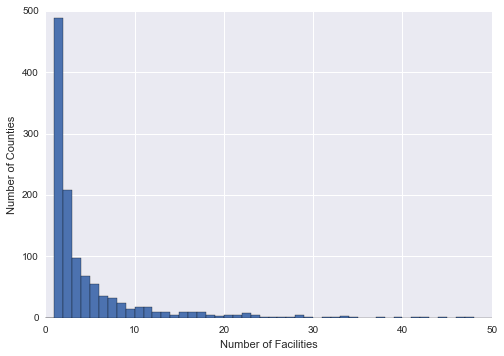

In [9]:
df = pd.DataFrame(rehab_dict)
fig = plt.hist(df['n_facilities'], bins=np.arange(0, 51, 1)) #max(df['n_facilities'])
plt.xlabel('Number of Facilities');
plt.ylabel('Number of Counties')